# Segmentation Analsis [IAR-271]

User Story: As an organization, we want to join our customer base to the market segments CMB identified so that we can contextualize and validate the segments based on our own users' shopping behaviors.

Acceptance Criteria:
* emails data (attached) are loaded to Redshift
* understand shopping behaviors by acquisition year, channel, likelihood to purchase at full-price, [product] category, and CLV.

## Import Library and Load Data

In [1]:
import warnings
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
import re
import scipy.stats as stats
from scipy.stats import norm
import pylab as pl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from bokeh.plotting import figure, show


%matplotlib inline

/Users/derekku/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
model_1 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_1.csv')
model_2 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_2.csv')
model_3 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_3.csv')
acq_year_1 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_1_acq_year.csv')
acq_year_2 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_2_acq_year.csv')
acq_year_3 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_3_acq_year.csv')
aov_2 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_2_aov.csv')
aov_3 = pd.read_csv('../Jupyter/segmentation_2017-11-15/model_3_aov.csv')

In [3]:
# Query for Acquisition Year
# select distinct o.customer_key, extract(year from o.order_date::date) as acquisition_year
# from pantalytics.ia_segmentation_customers sc
#   join pii.sk_customer_dim cd on sc.customer_email = cd.email
#   join pantalytics.spree_order_fact o on o.customer_key = cd.customer_key
# where o.new_repeat = 'New';

## Cleaning Data

In [4]:
#lower case to make class consistent
model_1['class'] = model_1['class'].str.lower()
model_2['class'] = model_2['class'].str.lower()
model_3['class'] = model_3['class'].str.lower()

#convert order_date from object to datetime
model_1['order_date'] = model_1.order_date.astype('datetime64[D]')
model_2['order_date'] = model_2.order_date.astype('datetime64[D]')
model_3['order_date'] = model_3.order_date.astype('datetime64[D]')

In [5]:
#group customers by segment name and acquisition year
acq_year_1_groupby = acq_year_1.groupby(['acquisition_year','segment_name']).count().unstack(level=1,fill_value=0)
acq_year_2_groupby = acq_year_2.groupby(['acquisition_year','segment_name']).count().unstack(level=1,fill_value=0)
acq_year_3_groupby = acq_year_3.groupby(['acquisition_year','segment_name']).count().unstack(level=1,fill_value=0)

acq_year_1_groupby = acq_year_1_groupby.reindex_axis(acq_year_1_groupby.sum().sort_values(ascending=False).index, axis=1)
acq_year_2_groupby = acq_year_2_groupby.reindex_axis(acq_year_2_groupby.sum().sort_values(ascending=False).index, axis=1)
acq_year_3_groupby = acq_year_3_groupby.reindex_axis(acq_year_3_groupby.sum().sort_values(ascending=False).index, axis=1)

In [6]:
#group customers by segment name and product_type (class)
product_type_1_groupby = model_1.groupby(['class','segment_name'])['model_id'].count().unstack(level=1,fill_value=0)
product_type_2_groupby = model_2.groupby(['class','segment_name'])['model_id'].count().unstack(level=1,fill_value=0)
product_type_3_groupby = model_3.groupby(['class','segment_name'])['model_id'].count().unstack(level=1,fill_value=0)

product_type_1_groupby = product_type_1_groupby.reindex_axis(product_type_1_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['fashionisto'],ascending=False)
product_type_2_groupby = product_type_2_groupby.reindex_axis(product_type_2_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['fit'],ascending=False)
product_type_3_groupby = product_type_3_groupby.reindex_axis(product_type_3_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['fashion_forward'],ascending=False)

In [7]:
#group customers by segment name and product_type (class)
price_type_1_groupby = model_1.groupby(['segment_name','price_type'])['model_id'].count().unstack(level=1,fill_value=0)
price_type_2_groupby = model_2.groupby(['segment_name','price_type'])['model_id'].count().unstack(level=1,fill_value=0)
price_type_3_groupby = model_3.groupby(['segment_name','price_type'])['model_id'].count().unstack(level=1,fill_value=0)

price_type_1_groupby = price_type_1_groupby.reindex_axis(price_type_1_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['Promotion'],ascending=False)
price_type_2_groupby = price_type_2_groupby.reindex_axis(price_type_2_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['Promotion'],ascending=False)
price_type_3_groupby = price_type_3_groupby.reindex_axis(price_type_3_groupby.sum().sort_values(ascending=False).index, axis=1).sort_values(['Promotion'],ascending=False)

In [8]:
clv_1_groupby = model_1.groupby(['segment_name'])['clv_revenue_52_weeks'].mean()
aov_1_groupby = model_1.groupby(['segment_name'])['revenue_per_transaction'].mean()
avg_spend_1_groupby = model_1.groupby(['segment_name'])['avg_spend'].mean()

clv_2_groupby = aov_2.groupby(['segment_name'])['avg_clv_rev'].mean()
aov_2_groupby = aov_2.groupby(['segment_name'])['aov'].mean()
avg_spend_2_groupby = aov_2.groupby(['segment_name'])['avg_spend'].mean()

clv_3_groupby = aov_3.groupby(['segment_name'])['avg_clv_rev'].mean()
aov_3_groupby = aov_3.groupby(['segment_name'])['aov'].mean()
avg_spend_3_groupby = aov_3.groupby(['segment_name'])['avg_spend'].mean()

## Feature Engineering 

In [9]:
# Create Table for AOV, CLV, & Average Spend (Model 2)
aov_2_table = [aov_2.segment_name.sort_values().unique(),aov_2_groupby.values,clv_2_groupby.values,avg_spend_2_groupby.values]
aov_2_df = pd.DataFrame(aov_2_table)

new_header = aov_2_df.iloc[0] #grab the first row for the header
aov_2_df = aov_2_df[1:] #take the data less the header row
aov_2_df.columns = new_header #set the header row as the df header
aov_2_df_t = aov_2_df.T
aov_2_df_t.columns = ['aov','clv','avg_spend']
aov_2_df = aov_2_df_t.T

In [10]:
# Create Table for AOV, CLV, & Average Spend (Model 3)
aov_3_table = [aov_3.segment_name.sort_values().unique(),aov_3_groupby.values,clv_3_groupby.values,avg_spend_3_groupby.values]
aov_3_df = pd.DataFrame(aov_3_table)

new_header = aov_3_df.iloc[0] #grab the first row for the header
aov_3_df = aov_3_df[1:] #take the data less the header row
aov_3_df.columns = new_header #set the header row as the df header
aov_3_df_t = aov_3_df.T
aov_3_df_t.columns = ['aov','clv','avg_spend']
aov_3_df = aov_3_df_t.T

## Data Exploration

### By AOV, CLV, & Average Spend

In [11]:
aov_2_df = aov_2_df.reindex_axis(aov_2_df.sum().sort_values(ascending=False).index, axis=1).sort_values(['affluent_brand_loyalist'],ascending=False)
aov_2_df = aov_2_df.T

In [12]:
aov_2_df['diff_clv_avg_spend'] = aov_2_df['clv'] - aov_2_df['avg_spend']
aov_2_df['diff_avg_spend_aov'] = aov_2_df['avg_spend'] - aov_2_df['aov']

In [13]:
#choose the model with the smallest delta between all models. 
aov_2_df['diff_clv_avg_spend'].values.sum()

1350.0183272541256

In [14]:
aov_2_df['diff_avg_spend_aov'].values.sum()

1251.3125187003968

In [15]:
aov_2_df.T

,affluent_brand_loyalist,urban_fashion,fit,practical,average_dresser,low_effort
clv,727.552,762.339,762.73,437.476,507.448,382.473
avg_spend,651,528,384,291,218,158
aov,162.815,200.61,192.19,156.3,138.509,128.264
diff_clv_avg_spend,76.5524,234.339,378.73,146.476,289.448,224.473
diff_avg_spend_aov,488.185,327.39,191.81,134.7,79.4911,29.7358


In [16]:
aov_3_df = aov_3_df.reindex_axis(aov_3_df.sum().sort_values(ascending=False).index, axis=1).sort_values(['fashion_forward'],ascending=False)
aov_3_df = aov_3_df.T

In [17]:
aov_3_df['diff_clv_avg_spend'] = aov_3_df['clv'] - aov_3_df['avg_spend']
aov_3_df['diff_avg_spend_aov'] = aov_3_df['avg_spend'] - aov_3_df['aov']

In [18]:
aov_3_df['diff_clv_avg_spend'].values.sum()

1569.9068670758516

In [19]:
aov_3_df['diff_avg_spend_aov'].values.sum()

1339.9291887708578

In [20]:
aov_3_df.T

,fashion_forward,fashionistos,the_hit-or-miss_explorers,quality_and_fit_focused,price_and_fit_focused,average_joes,dudes_that_dont_care
clv,806.165,792.973,547.809,535.687,579.424,384.962,411.886
avg_spend,555,570,427,328,251,235,123
aov,192.623,145.956,214.508,173.098,152.702,143.915,126.269
diff_clv_avg_spend,251.165,222.973,120.809,207.687,328.424,149.962,288.886
diff_avg_spend_aov,362.377,424.044,212.492,154.902,98.2984,91.0854,-3.26867


#### The sum of the deltas between "CLV" & "Average Spend" in Model 2 (1350) is slightly smaller than Model 3 (1570). The sum of the deltas between "AOV" & "Average Spend" in Model 2 (1251) is slightly smaller than Model 3 (1340).

In [21]:
clv_2_sort = aov_2.avg_clv_rev.sort_values(ascending=True)
clv_2_clean  = clv_2_sort[clv_2_sort!=0].dropna(axis=0, how='any')
fit = stats.norm.pdf(clv_2_clean, np.mean(clv_2_clean), np.std(clv_2_clean))  #this is a fitting indeed

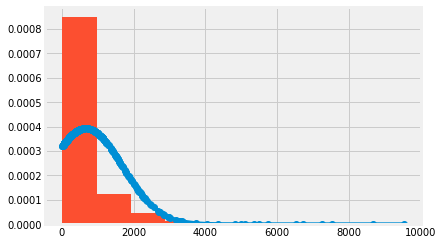

In [22]:
pl.plot(clv_2_clean,fit,'-o')
pl.hist(clv_2_clean,normed=True)
pl.show() 

In [23]:
clv_3_sort = aov_3.avg_clv_rev.sort_values(ascending=True)
clv_3_clean  = clv_3_sort[clv_3_sort!=0].dropna(axis=0, how='any')
fit = stats.norm.pdf(clv_3_clean, np.mean(clv_3_clean), np.std(clv_3_clean))  #this is a fitting indeed

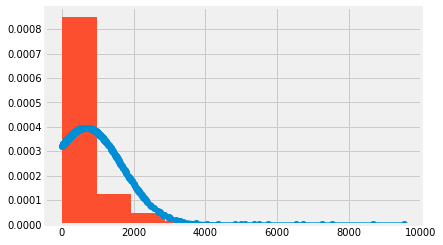

In [24]:
pl.plot(clv_3_clean,fit,'-o')
pl.hist(clv_3_clean,normed=True)
pl.show() 

In [38]:
clv_pct_2 = pd.read_csv('../Jupyter/segmentation_2017-11-15/clv_pct_2.csv')
clv_pct_3 = pd.read_csv('../Jupyter/segmentation_2017-11-15/clv_pct_3.csv')

In [39]:
clv_pct_2.clv.astype('int')

0         0
1        16
2        18
3        20
4        27
5        30
6        32
7        34
8        36
9        38
10       38
11       40
12       41
13       44
14       44
15       46
16       47
17       48
18       48
19       49
20       49
21       50
22       50
23       51
24       52
25       53
26       53
27       54
28       54
29       55
       ... 
625    2713
626    2718
627    2723
628    2733
629    2824
630    2843
631    2851
632    2947
633    2977
634    3009
635    3092
636    3190
637    3305
638    3357
639    3366
640    3740
641    4044
642    4360
643    4781
644    4996
645    5004
646    5348
647    5500
648    5741
649    6727
650    7159
651    7530
652    7922
653    8677
654    9443
Name: clv, Length: 655, dtype: int64

In [40]:
clv_pct_2 = clv_pct_2.set_index('clv')

In [42]:
clv_pct_3 = clv_pct_3.set_index('clv')

In [1118]:
clv_pct_3 = clv_pct_3.set_index('clv')

In [61]:
clv_pct_2

KeyError: 250

In [53]:
clv_pct_2_limit = clv_pct_2[clv_pct_2['fit'] < 0.90]

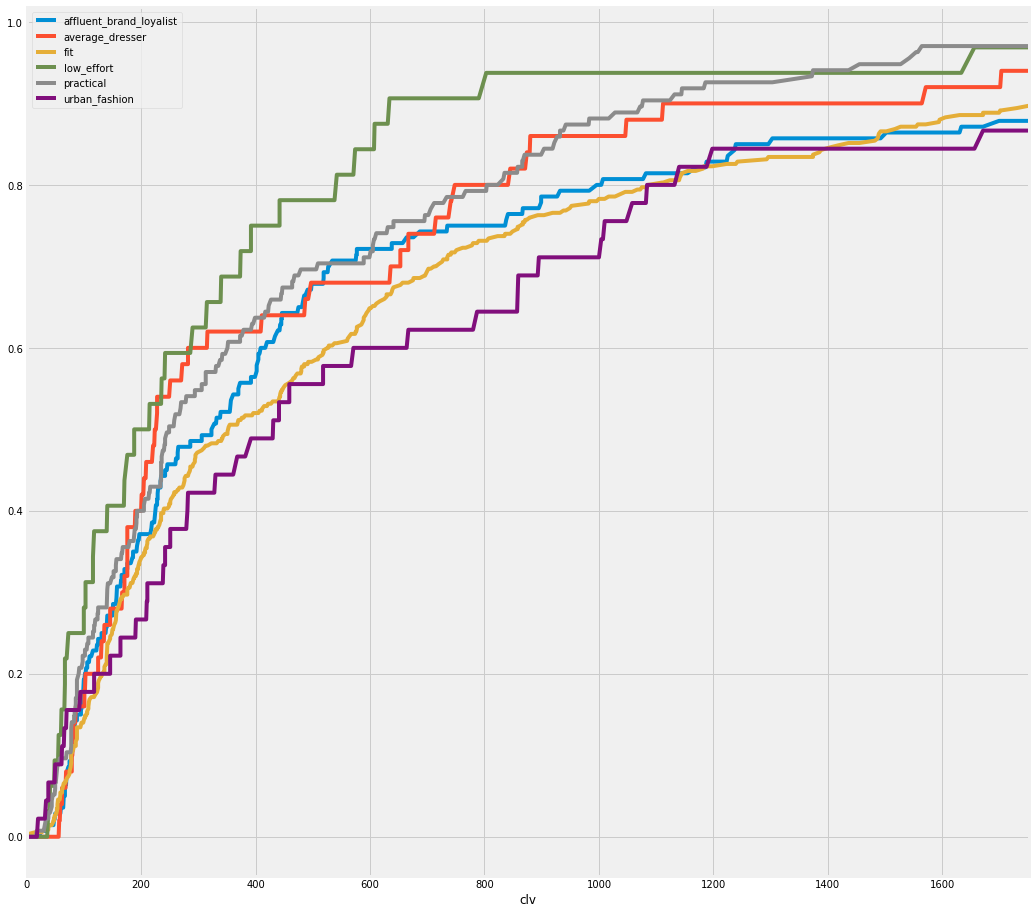

In [54]:
plt.figure()
clv_pct_2_limit.plot(figsize=(16, 16))
plt.legend(loc='best')
#plt.axis([0, 2500, 0.0, 1.0])

In [59]:
clv_pct_3_limit = clv_pct_3[clv_pct_3['fashion_forward'] < 0.90]

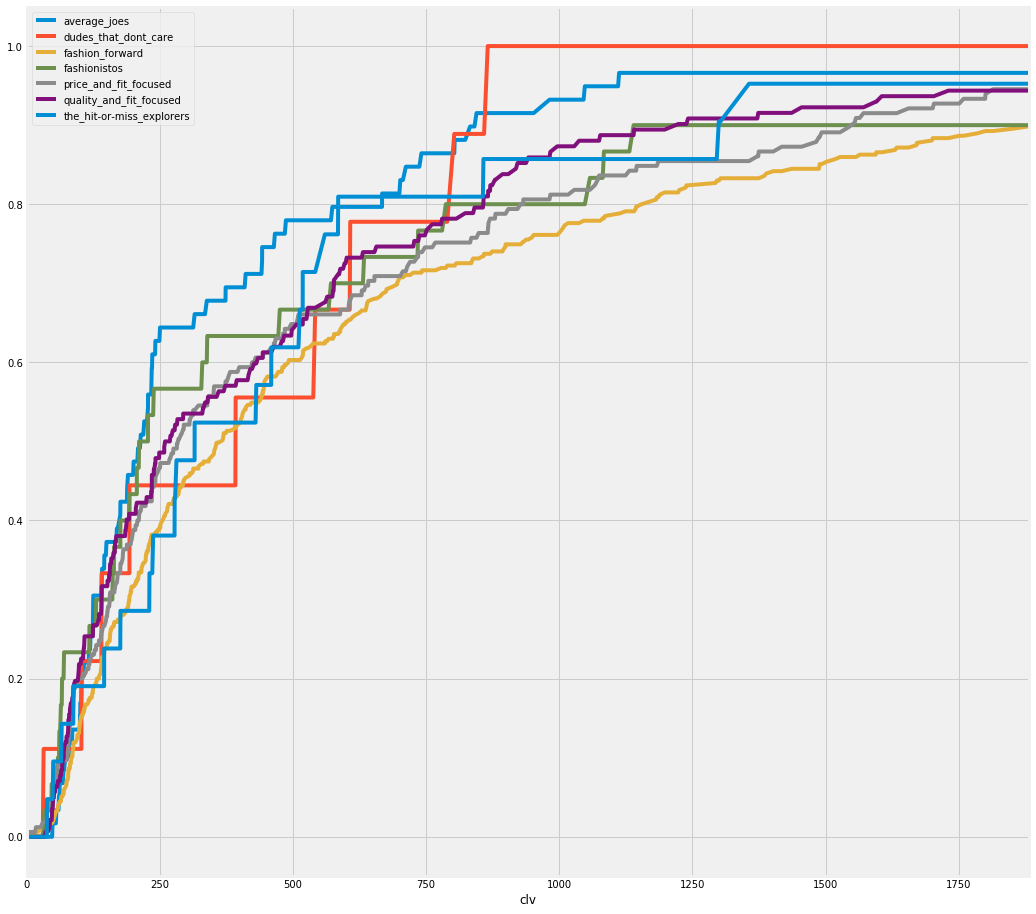

In [58]:
plt.figure()
clv_pct_3_limit.plot(figsize=(16, 16))
plt.legend(loc='best')
#plt.setp(color='r', linewidth=2.0)

### By Acquisition Year

In [872]:
acq_year_1_groupby

customer_key                                               
segment_name      fashionisto winning_uniform simple_comfort special_details
acquisition_year                                                            
2008                        2               1              0               0
2009                        6               1              1               2
2010                        6               6              3               0
2011                       20               6             12               2
2012                       24              13              9               6
2013                       51              12             13              10
2014                       51              20             25               8
2015                       71              24             18               8
2016                       83              20             22              18
2017                       97              36             27              19

In [873]:
acq_year_2_groupby

customer_key                                    \
segment_name              fit affluent_brand_loyalist practical   
acquisition_year                                                  
2008                        3                       0         0   
2009                        2                       0         5   
2010                        7                       5         1   
2011                       19                       5         9   
2012                       20                       8        12   
2013                       40                      17        17   
2014                       52                      19        18   
2015                       56                      23        19   
2016                       71                      22        28   
2017                       80                      41        25   

                                                           
segment_name     average_dresser urban_fashion low_effort  
acquisition_year                                           
2008                           0             0          0  
2009                           2             0          2  
2010                           0             1          1  
2011                           3             1          3  
2012                           5             3          4  
2013                           4             6          3  
2014                           7             5          2  
2015                           9            11          4  
2016                           7             7          5  
2017                          13            11          8

In [881]:
acq_year_3_groupby

customer_key                        \
segment_name     fashion_forward price_and_fit_focused   
acquisition_year                                         
2008                           2                     0   
2009                           4                     0   
2010                           6                     5   
2011                          17                     3   
2012                          20                    17   
2013                          42                    15   
2014                          48                    25   
2015                          55                    29   
2016                          61                    31   
2017                          80                    40   

                                                                    \
segment_name     quality_and_fit_focused average_joes fashionistos   
acquisition_year                                                     
2008                                   0            1            0   
2009                                   2            4            1   
2010                                   2            0            1   
2011                                  11            4            0   
2012                                   9            5            0   
2013                                  19            6            5   
2014                                  16            7            3   
2015                                  21           10            6   
2016                                  31            7            4   
2017                                  32           15           10   

                                                                 
segment_name     the_hit-or-miss_explorers dudes_that_dont_care  
acquisition_year                                                 
2008                                     0                    0  
2009                                     0                    0  
2010                                     1                    0  
2011                                     2                    3  
2012                                     1                    0  
2013                                     0                    0  
2014                                     3                    3  
2015                                     1                    1  
2016                                     8                    2  
2017                                     5                    1

In [981]:
aov_3_sort = aov_3.sort_values(by=['avg_clv_rev'],ascending=True).dropna(axis=0, how='any')
aov_3_sort['counter'] = 1
aov_3_sort['cum_sum'] = aov_3_sort.counter.cumsum()
aov_3_sort['cum_perc'] = 100*aov_3_sort.cum_sum/aov_3_sort.counter.sum()

In [1033]:
aov_clv_model_2 = pd.read_csv('../Jupyter/segmentation_2017-11-15/AOV_CLV_MODEL_2.csv')

In [1037]:
aov_clv_model_2['avg_clv_rev'] = aov_clv_model_2[' avg_clv_rev ']

In [1040]:
aov_clv_model_2['avg_clv_rev']

0          20.00 
1          33.60 
2          38.40 
3          50.00 
4          61.60 
5          66.00 
6          70.40 
7          93.80 
8         118.00 
9         146.00 
10        164.20 
11        191.10 
12        209.80 
13        211.20 
14        238.76 
15        241.98 
16        251.05 
17        281.39 
18        282.00 
19        329.84 
20        367.90 
21        391.50 
22        431.20 
23        441.00 
24        459.45 
25        518.40 
26        571.40 
27        667.20 
28        787.00 
29        857.60 
          ...    
722       932.00 
723       996.20 
724     1,007.21 
725     1,081.50 
726     1,168.50 
727     1,188.40 
728     1,225.00 
729     1,237.00 
730     1,238.66 
731     1,302.70 
732     1,501.80 
733     1,633.40 
734     1,699.38 
735     1,923.40 
736     1,973.29 
737     2,014.96 
738     2,131.40 
739     2,142.90 
740     2,193.52 
741     2,195.84 
742     2,307.05 
743     2,341.40 
744     2,467.65 
745     2,722.65 
746     3,

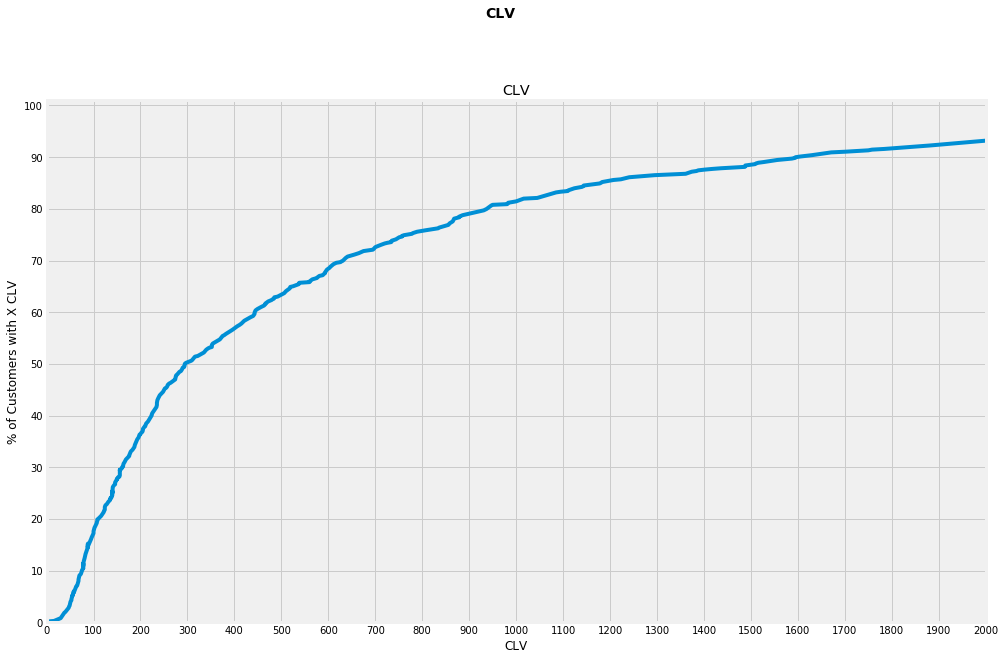

In [1002]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('CLV', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('CLV')

ax.set_xlabel('CLV')
ax.set_ylabel('% of Customers with X CLV')

ax.set_xticks(np.arange(0, 2001, 100))
ax.set_yticks(np.arange(0, 101, 10))

ax.set_xlim([0, 2001])
ax.set_ylim([0, 101])

#ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#            arrowprops=dict(facecolor='black', shrink=0.05))

y = fit_2_sort['cum_perc'].astype("float32") #set cumsum to y
x = fit_2_sort['avg_clv_rev'].astype("int")


plt.plot(x,y)

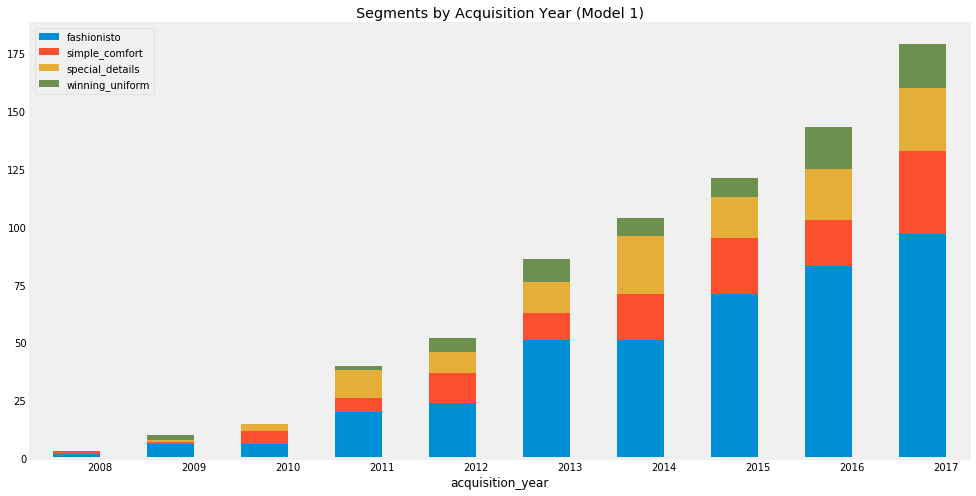

In [875]:
fig, ax = plt.subplots(figsize=(15, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Acquisition Year (Model 1)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=['fashionisto','simple_comfort','special_details','winning_uniform'])

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = acq_year_1_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 1"])

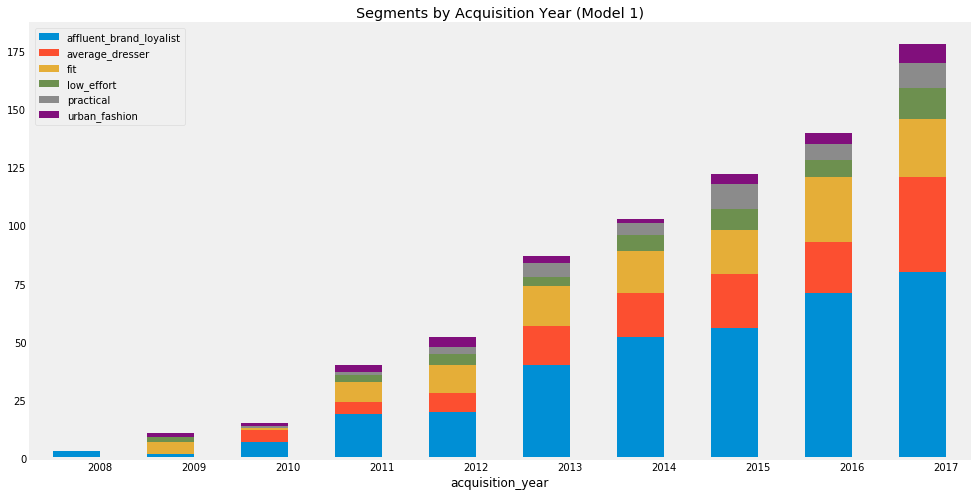

In [876]:
fig, ax = plt.subplots(figsize=(15, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Acquisition Year (Model 1)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=['affluent_brand_loyalist','average_dresser','fit','low_effort','practical','urban_fashion'])

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = acq_year_2_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 2"])

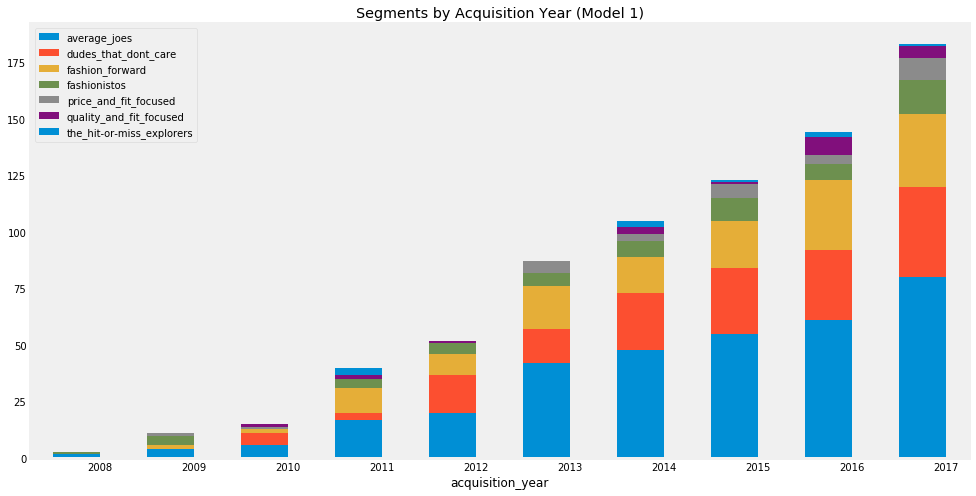

In [877]:
fig, ax = plt.subplots(figsize=(15, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Acquisition Year (Model 1)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=['average_joes','dudes_that_dont_care','fashion_forward','fashionistos','price_and_fit_focused','quality_and_fit_focused','the_hit-or-miss_explorers'])

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = acq_year_3_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 3"])

### By Product Category

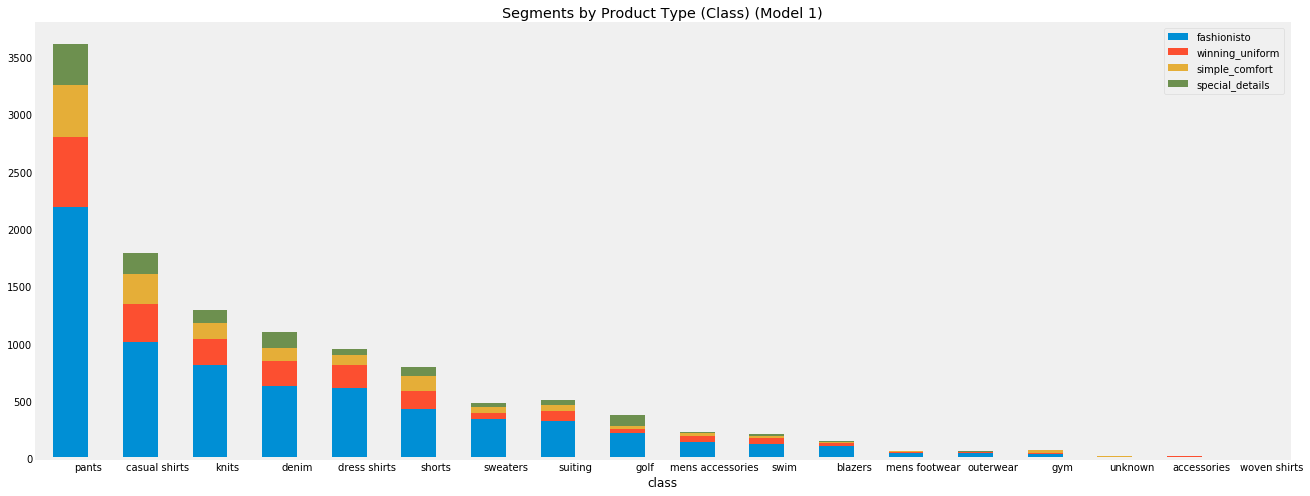

In [878]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Product Type (Class) (Model 1)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=product_type_1_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = product_type_1_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 1"])

In [1073]:
#aov_clv_model_2.cum_perc[aov_clv_model_2['segment_name'] == 'urban_fashion'].values.astype("float32").tolist()
aov_clv_model_2.avg_clv_rev.isnull().values.sum()

0

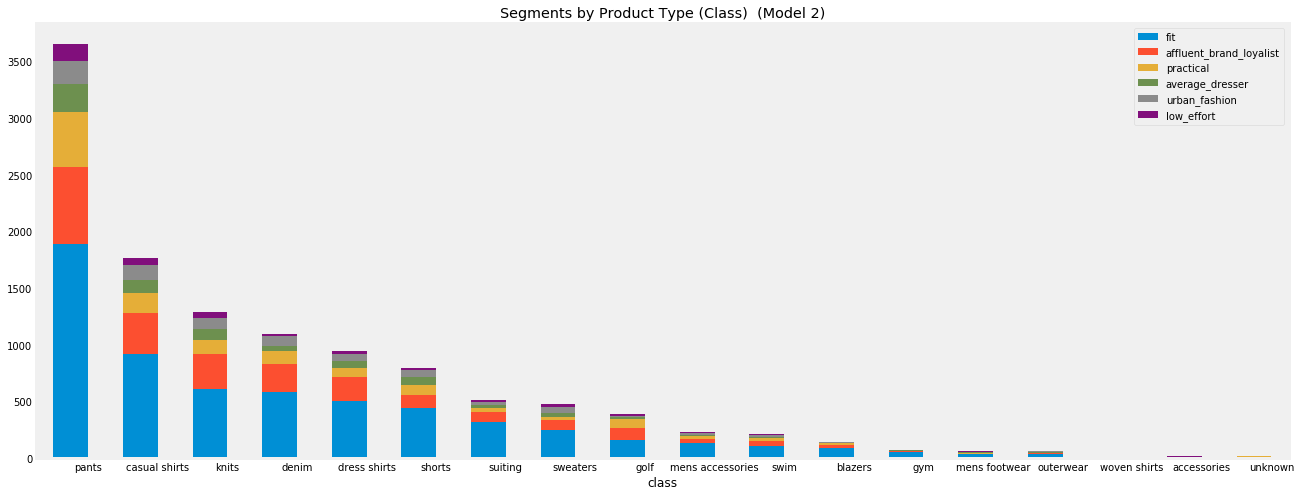

In [879]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Product Type (Class)  (Model 2)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=product_type_2_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = product_type_2_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 2"])

In [907]:
product_type_2_groupby['avg_amt_product_sold'] = product_type_2_groupby.T.mean()
product_type_2_groupby['fit_index'] = product_type_2_groupby.fit.astype('float') / product_type_2_groupby.avg_amt_product_sold
product_type_2_groupby['affluent_brand_loyalist_index'] = product_type_2_groupby.affluent_brand_loyalist.astype('float') / product_type_2_groupby.avg_amt_product_sold
product_type_2_groupby['practical_index'] = product_type_2_groupby.practical.astype('float') / product_type_2_groupby.avg_amt_product_sold
product_type_2_groupby['average_dresser_index'] = product_type_2_groupby.average_dresser.astype('float') / product_type_2_groupby.avg_amt_product_sold
product_type_2_groupby['urban_fashion_index'] = product_type_2_groupby.urban_fashion.astype('float') / product_type_2_groupby.avg_amt_product_sold
product_type_2_groupby['low_effort_index'] = product_type_2_groupby.low_effort.astype('float') / product_type_2_groupby.avg_amt_product_sold



segment_name,fit,affluent_brand_loyalist,practical,average_dresser,urban_fashion,low_effort,avg_amt_product_sold,fit_index,affluent_brand_loyalist_index,practical_index,average_dresser_index,urban_fashion_index,low_effort_index
class,,,,,,,,,,,,,
pants,1894,680,484,242,208,146,328.384615,5.767627,2.070743,1.473881,0.736941,0.633404,0.444601
casual shirts,923,357,174,119,128,64,158.858974,5.810185,2.247276,1.095311,0.749092,0.805746,0.402873
knits,615,309,120,101,90,52,115.961538,5.303483,2.664677,1.034826,0.870978,0.776119,0.448425
denim,581,248,120,46,83,23,99.269231,5.852770,2.498256,1.208834,0.463386,0.836110,0.231693
dress shirts,509,210,77,62,64,29,85.807692,5.931869,2.447333,0.897355,0.722546,0.745854,0.337965
shorts,448,114,87,67,63,19,72.076923,6.215582,1.581644,1.207044,0.929562,0.874066,0.263607
suiting,323,88,37,26,24,14,46.410256,6.959669,1.896133,0.797238,0.560221,0.517127,0.301657
sweaters,246,91,26,37,51,27,43.358974,5.673566,2.098758,0.599645,0.853341,1.176227,0.622708
golf,161,103,80,20,12,12,35.282051,4.563227,2.919331,2.267442,0.566860,0.340116,0.340116


In [933]:
product_type_3_groupby.to_csv('../Jupyter/prod_type_3_groupby.csv')


In the 'Fit' segment of Model 2, the Fit's index for 'Suiting' (6.96x), 'Blazer' (6.90x), and 'Gym' (7.37x) stand out—meaning that the customers belonging in Fit are:
* 6.96x likely to buy an item in 'Suiting' than the average Bonobos customer in the sample
* 6.90x likely to buy a 'Blazer' than the average Bonobos customer in the sample
* 7.37x likely to buy an item in the 'Gym' category than the average Bonobos customer in the sample

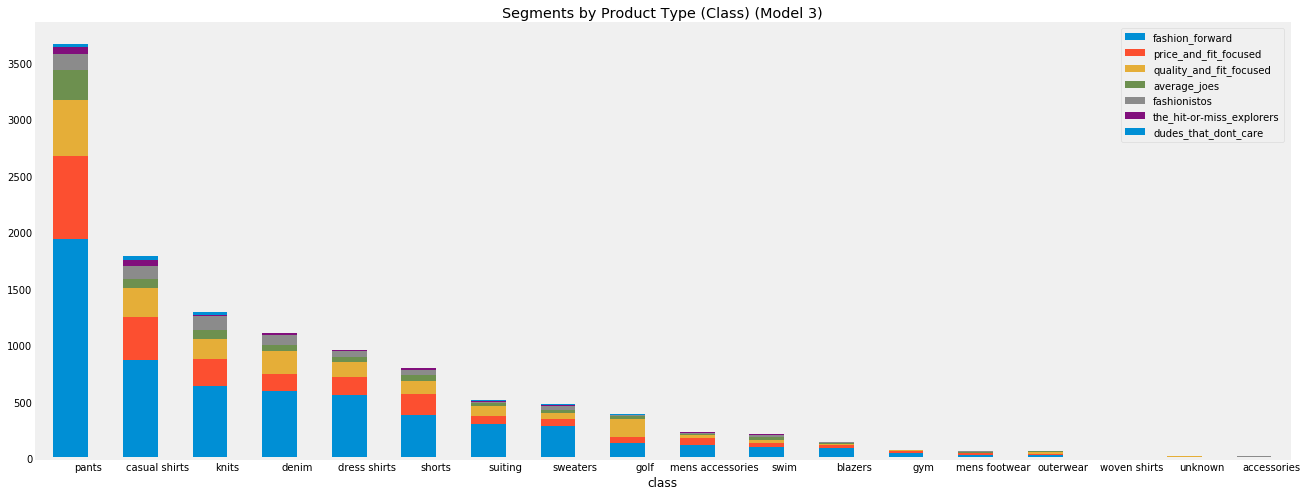

In [880]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Product Type (Class) (Model 3)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=product_type_3_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = product_type_3_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 3"])

In [910]:
product_type_3_groupby['avg_amt_product_sold'] = product_type_3_groupby.T.mean()
product_type_3_groupby['fashion_forward_index'] = product_type_3_groupby.fashion_forward.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['price_and_fit_focused_index'] = product_type_3_groupby.price_and_fit_focused.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['quality_and_fit_focused_index'] = product_type_3_groupby.quality_and_fit_focused.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['average_joes_index'] = product_type_3_groupby.average_joes.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['fashionistos_index'] = product_type_3_groupby.fashionistos.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['the_hit-or-miss_explorers_index'] = product_type_3_groupby['the_hit-or-miss_explorers'].astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby['dudes_that_dont_care_index'] = product_type_3_groupby.dudes_that_dont_care.astype('float') / product_type_3_groupby.avg_amt_product_sold
product_type_3_groupby

segment_name,fashion_forward,price_and_fit_focused,quality_and_fit_focused,average_joes,fashionistos,the_hit-or-miss_explorers,dudes_that_dont_care,avg_amt_product_sold,fashion_forward_index,price_and_fit_focused_index,quality_and_fit_focused_index,average_joes_index,fashionistos_index,the_hit-or-miss_explorers_index,dudes_that_dont_care_index
class,,,,,,,,,,,,,,,
pants,1939,734,500,261,145,58,28,419.367675,4.623628,1.750254,1.192271,0.622366,0.345759,0.138303,0.066767
casual shirts,874,372,261,83,113,52,36,205.172705,4.259826,1.813107,1.272099,0.404537,0.550756,0.253445,0.175462
knits,638,242,175,81,124,12,23,148.475676,4.297000,1.629897,1.178644,0.545544,0.835154,0.080821,0.154908
denim,599,150,203,53,87,15,5,127.557207,4.695932,1.175943,1.591443,0.415500,0.682047,0.117594,0.039198
dress shirts,559,156,138,46,47,11,1,110.008157,5.081441,1.418077,1.254452,0.418151,0.427241,0.099993,0.009090
shorts,386,186,109,52,50,15,2,91.929071,4.198889,2.023299,1.185697,0.565653,0.543898,0.163169,0.021756
suiting,307,70,82,31,6,13,3,59.029715,5.200770,1.185843,1.389131,0.525159,0.101644,0.220228,0.050822
sweaters,287,60,53,30,33,5,12,55.363185,5.183950,1.083753,0.957315,0.541876,0.596064,0.090313,0.216751
golf,139,47,166,20,7,8,2,44.791847,3.103243,1.049298,3.706032,0.446510,0.156278,0.178604,0.044651


In the 'Fashion Forward' segment of Model 3, the indices for 'Dress Shirt' (5.08x), 'Suiting' (5.20x), 'Sweater' (5.18x), 'Blazer' (5.41x), and 'Gym' (5.23x) stand out—meaning that the customers belonging in 'Fashion Forward' are:
* 5.08x likely to buy a 'Dress Shirt' than the average Bonobos customer in the sample
* 5.20x likely to buy a 'Suiting' item than the average Bonobos customer in the sample
* 5.18x likely to buy a 'Sweater' than the average Bonobos customer in the sample
* 5.41x likely to buy a 'Blazer' than the average Bonobos customer in the sample
* 5.23x likely to buy an item in the 'Gym' category than the average Bonobos customer in the sample

The 'Fashion Forward' segment of Model 3 has the second highest propensity to purchase full price out of all segments and the highest average CLV of $806.17.

In the 'Quality & Fit Focused' segment of Model 3, the index for 'Golf' (3.71x) stands out. This segment also has the highest propensity to purchase full price out of all segments and an average CLV of $535.69.

### By Price Type (Full Price or Discount)

In [803]:
#price_type_1_groupby.T[['fashionisto']].values.sum() 
price_type_2_groupby.T

segment_name,fit,affluent_brand_loyalist,practical,urban_fashion,average_dresser,low_effort
price_type,,,,,,
Promotion,2316,828,479,309,283,208
Markdown,1899,818,470,247,316,147
Full Price,2006,690,350,211,189,67


In [802]:
price_type_3_groupby.T

segment_name,fashion_forward,price_and_fit_focused,quality_and_fit_focused,fashionistos,average_joes,the_hit-or-miss_explorers,dudes_that_dont_care
price_type,,,,,,,
Promotion,2279,903,595,297,275,74,33
Markdown,2033,722,549,187,278,86,73
Full Price,1896,565,651,187,175,41,11


price_type_2_groupby.T

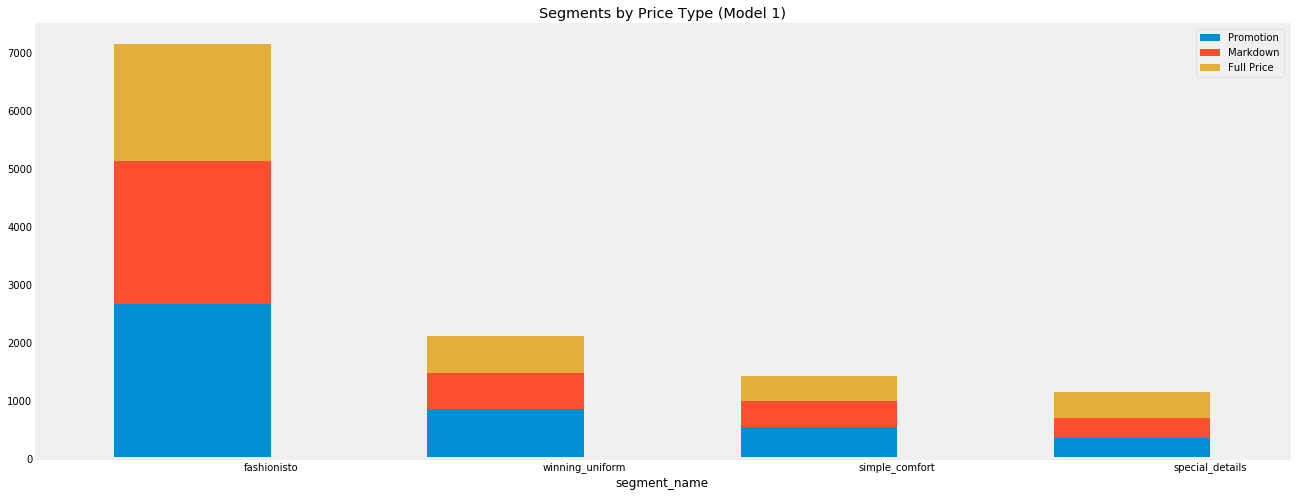

In [619]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Price Type (Model 1)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=price_type_1_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = price_type_1_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 1"])

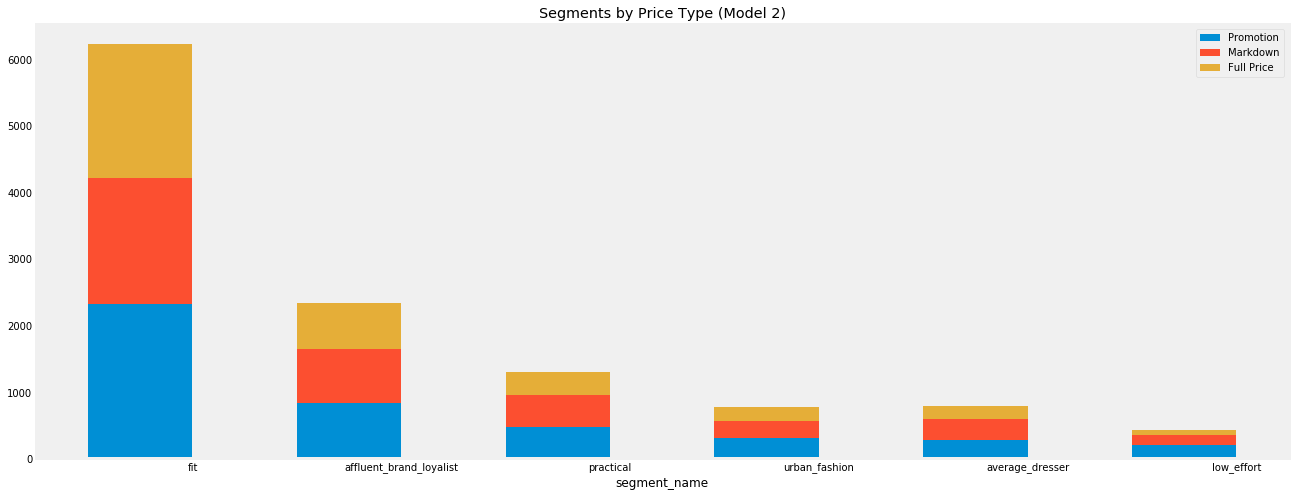

In [620]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Price Type (Model 2)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=price_type_2_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = price_type_2_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 2"])

In [925]:
price_type_2_groupby['full_price_pct'] = price_type_2_groupby['Full Price']  / (price_type_2_groupby['Promotion'] + price_type_2_groupby['Markdown'] + price_type_2_groupby['Full Price'])
price_type_2_groupby['discount_pct'] = 1 - price_type_2_groupby['full_price_pct']

In [926]:
price_type_2_groupby

price_type,Promotion,Markdown,Full Price,full_price_pct,discount_pct
segment_name,,,,,
fit,2316,1899,2006,0.322456,0.677544
affluent_brand_loyalist,828,818,690,0.295377,0.704623
practical,479,470,350,0.269438,0.730562
urban_fashion,309,247,211,0.275098,0.724902
average_dresser,283,316,189,0.239848,0.760152
low_effort,208,147,67,0.158768,0.841232


The 'fit' segment in model 2 has the greatest percentage of customers paying full price at 32.25%, compared to the other segments ranging from 15.88% - 29.53%.

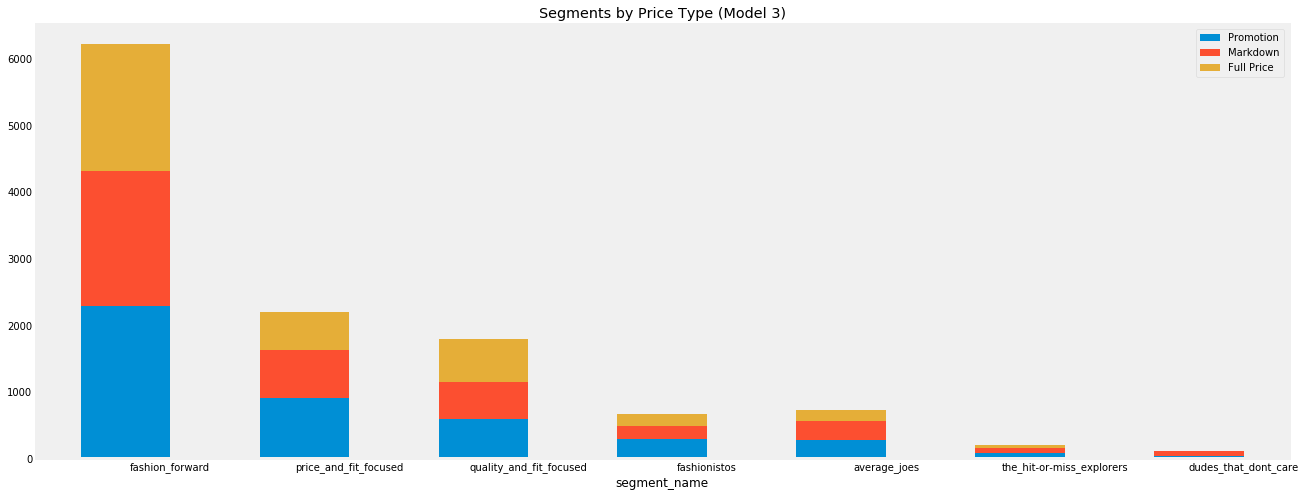

In [621]:
fig, ax = plt.subplots(figsize=(20, 8))

def plot_clustered_stacked(dfall, labels=None, title="Segments by Price Type (Model 3)",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
#         for j, pa in enumerate(h[i:i+n_col]):
#             for rect in pa.patches: # for each index
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
#                 rect.set_hatch(H * int(i / n_col)) #edited part     
#                 rect.set_width(1 / float(n_df + 1))
    axe.legend(labels=price_type_3_groupby.columns.values.tolist())

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
#     n=[]        
#     for i in range(n_df):
#         n.append(axe.bar(0, 0, color="gray", hatch=H * i))

#     l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
#     if labels is not None:
#         l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
#     axe.add_artist(l1)
#     return axe

# create fake dataframes
df1 = price_type_3_groupby

# Then, just call :
plot_clustered_stacked([df1],["Model 3"])

In [927]:
price_type_3_groupby['full_price_pct'] = price_type_3_groupby['Full Price']  / (price_type_3_groupby['Promotion'] + price_type_3_groupby['Markdown'] + price_type_3_groupby['Full Price'])
price_type_3_groupby['discount_pct'] = 1 - price_type_3_groupby['full_price_pct']
price_type_3_groupby

price_type,Promotion,Markdown,Full Price,full_price_pct,discount_pct
segment_name,,,,,
fashion_forward,2279,2033,1896,0.305412,0.694588
price_and_fit_focused,903,722,565,0.257991,0.742009
quality_and_fit_focused,595,549,651,0.362674,0.637326
fashionistos,297,187,187,0.278689,0.721311
average_joes,275,278,175,0.240385,0.759615
the_hit-or-miss_explorers,74,86,41,0.203980,0.796020
dudes_that_dont_care,33,73,11,0.094017,0.905983


In [935]:
price_type_2_groupby.to_csv('../Jupyter/price_type_2.csv')

The 'Quality and Fit Focused' segment in model 3 has the greatest percentage of customers paying full price at 36.27%, compared to the other segments ranging from 9.40% - 30.54%.

## Analysis

**From a AOV & CLV standpoint:** 

We found that Model 3 had more variability than Model 2 to the AOV and CLV data that we calculated for the segmentation sample. The sum of the deltas between "CLV" & "Average Spend" in Model 2 (1350) is slightly smaller than Model 3 (1570). The sum of the deltas between "AOV" & "Average Spend" in Model 2 (1251) is slightly smaller than Model 3 (1340).


**From a Product Type (Class) standpoint:**

In the top segment of Model 2, Fit's index for 'Suiting' (6.96x), 'Blazer' (6.90x), and 'Gym' (7.37x) stand out—meaning that the customers belonging in Fit are:
* 6.96x likely to buy an item in 'Suiting' than the average Bonobos customer in the sample
* 6.90x likely to buy a 'Blazer' than the average Bonobos customer in the sample
* 7.37x likely to buy an item in the 'Gym' category than the average Bonobos customer in the sample

In the 'Fashion Forward' segment of Model 3, the indices for 'Dress Shirt' (5.08x), 'Suiting' (5.20x), 'Sweater' (5.18x), 'Blazer' (5.41x), and 'Gym' (5.23x) stand out—meaning that the customers belonging in 'Fashion Forward' are:
* 5.08x likely to buy a 'Dress Shirt' than the average Bonobos customer in the sample
* 5.20x likely to buy a 'Suiting' item than the average Bonobos customer in the sample
* 5.18x likely to buy a 'Sweater' than the average Bonobos customer in the sample
* 5.41x likely to buy a 'Blazer' than the average Bonobos customer in the sample
* 5.23x likely to buy an item in the 'Gym' category than the average Bonobos customer in the sample

The 'Fashion Forward' segment of Model 3 has the second highest propensity to purchase full price out of all segments and the highest average CLV of $806.17.

In the 'Quality & Fit Focused' segment of Model 3, the index for 'Golf' (3.71x) stands out. This segment also has the highest propensity to purchase full price out of all segments and an average CLV of $535.69.

**From a Price Type standpoint:** 

The 'Fit' segment in model 2 has the greatest percentage of customers paying full price at 32.25%, compared to the other segments ranging from 15.88% - 29.53%.

The 'Quality and Fit Focused' segment in model 3 has the greatest percentage of customers paying full price at 36.27%, compared to the other segments ranging from 9.40% - 30.54%.

Model 3 seems to have greater range of price type behavior, which may mean that model 3 is more descriptive at segmenting our customers. 

## Summary

1. 
2. TBD